In [1]:
import gym
from collections import deque
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import namedtuple

import matplotlib.pyplot as plt

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device_check:',device)

device_check: cuda


In [2]:
## hyperparameter
LR=0.0005
GAMMA=0.98
BUFFER_LIMIT=50000
BATCH_SIZE=32

Transition = namedtuple('Transition',
                        ('state', 'action', 'reward','next_state', 'done'))

In [3]:
class ReplayBuffer():
    def __init__(self):
        self.buffer =deque([],maxlen=BUFFER_LIMIT)  # double-ended queue

    def push(self, *args): ## deque --> append
        self.buffer.append(Transition(*args))
        
    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []

        for transition in mini_batch:
            s, a, r, next_state, done = transition
            s_lst.append(s);a_lst.append([a]);r_lst.append([r]);s_prime_lst.append(next_state);done_mask_lst.append([done])
            
        def list_to_tensor_float(lst):
            return torch.tensor(lst,dtype=torch.float).to(device)
        
        def list_to_tensor(lst):
            return torch.tensor(lst).to(device)
        
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst=list_to_tensor_float(s_lst),list_to_tensor(a_lst),list_to_tensor(r_lst),list_to_tensor_float(s_prime_lst),list_to_tensor(done_mask_lst)
        
        return s_lst,a_lst,r_lst,s_prime_lst,done_mask_lst

    def size(self):
        return len(self.buffer)

In [4]:
class DQN(nn.Module):
    def __init__(self,input_size,output_size):
        super(DQN, self).__init__()

        self.fc1 = nn.Linear(input_size, 128) ## state value(position,velocity) 총 2개
        self.fc2 = nn.Linear(128, 128)
        self.fc3=nn.Linear(128,64)
        self.fc4 = nn.Linear(64, output_size) ## action 후보 총 3개

    def forward(self, x):
        
        x = x.to(device)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x= F.relu(self.fc3(x))
        x = self.fc4(x)

        return x

    def sample_action(self, obs, epsilon):

        out = self.forward(obs)
        coin = random.random()

        if coin < epsilon:
            return random.randint(0, 1) ## exploration
        else:
            return out.argmax().item() ## exploitation

Iteration:1, Reward : -210.0
Iteration:2, Reward : -200.0
Iteration:3, Reward : -200.0
Iteration:4, Reward : -200.0
Iteration:5, Reward : -200.0
Iteration:6, Reward : -200.0
Iteration:7, Reward : -200.0
Iteration:8, Reward : -200.0
Iteration:9, Reward : -200.0
Iteration:10, Reward : -200.0
Iteration:11, Reward : -200.0
Iteration:12, Reward : -200.0
Iteration:13, Reward : -200.0
Iteration:14, Reward : -200.0
Iteration:15, Reward : -200.0
Iteration:16, Reward : -200.0
Iteration:17, Reward : -200.0
Iteration:18, Reward : -200.0
Iteration:19, Reward : -200.0
Iteration:20, Reward : -200.0
Iteration:21, Reward : -200.0
Iteration:22, Reward : -200.0
Iteration:23, Reward : -200.0
Iteration:24, Reward : -200.0
Iteration:25, Reward : -200.0
Iteration:26, Reward : -200.0
Iteration:27, Reward : -200.0
Iteration:28, Reward : -200.0
Iteration:29, Reward : -200.0
Iteration:30, Reward : -200.0
Iteration:31, Reward : -200.0
Iteration:32, Reward : -200.0
Iteration:33, Reward : -200.0
Iteration:34, Rewar

Iteration:269, Reward : -191.1
Iteration:270, Reward : -181.7
Iteration:271, Reward : -188.4
Iteration:272, Reward : -187.4
Iteration:273, Reward : -181.8
Iteration:274, Reward : -193.6
Iteration:275, Reward : -188.1
Iteration:276, Reward : -184.3
Iteration:277, Reward : -196.0
Iteration:278, Reward : -189.9
Iteration:279, Reward : -191.1
Iteration:280, Reward : -190.2
Iteration:281, Reward : -183.2
Iteration:282, Reward : -200.0
Iteration:283, Reward : -200.0
Iteration:284, Reward : -195.3
Iteration:285, Reward : -193.7
Iteration:286, Reward : -196.2
Iteration:287, Reward : -194.5
Iteration:288, Reward : -193.1
Iteration:289, Reward : -190.8
Iteration:290, Reward : -188.7
Iteration:291, Reward : -186.4
Iteration:292, Reward : -194.4
Iteration:293, Reward : -195.8
Iteration:294, Reward : -192.3
Iteration:295, Reward : -194.3
Iteration:296, Reward : -189.8
Iteration:297, Reward : -191.6
Iteration:298, Reward : -183.0
Iteration:299, Reward : -192.3
Iteration:300, Reward : -182.5
Iteratio

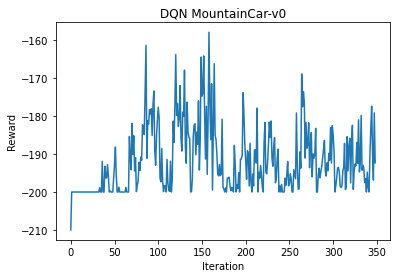

In [5]:
def train(q, q_target, memory, optimizer):

    for i in range(200): 
        s, a, r, s_prime, done_mask = memory.sample(BATCH_SIZE)

        q_out = q(s)
        q_a = q_out.gather(1, a)
        max_q_prime = q_target(s_prime).max(1)[0].unsqueeze(1) ## target_network
        target = r + GAMMA * max_q_prime * done_mask
        loss = F.mse_loss(q_a, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def start_train():

    env = gym.make('MountainCar-v0')
    
    input_size = env.observation_space.shape[0]
    output_size = env.action_space.n
    
    iteration=0
    num_traj=20  
    score=0
    
    reward_list=[]

    q = DQN(input_size, output_size).to(device)
    q_target = DQN(input_size, output_size).to(device)

    q_target.load_state_dict(q.state_dict()) ## 모델 불러오기
    memory = ReplayBuffer()

    optimizer = optim.Adam(q.parameters(), lr=LR)

    for n_epi in range(7000): ## iteration 횟수와 관련
        epsilon = max(0.01, 0.07 - 0.01 * (n_epi / 200))  # Linear annealing from 8% to 1%
        s = env.reset()
        done = False

        while not done:
            a = q.sample_action(torch.from_numpy(s).float(), epsilon)
            s_prime, r, done, info = env.step(a)  ## state, reward, terminal_state (1? NO, 0? Yes), probability
            done_mask = 0.0 if done else 1.0 ## 끝났으면 0 이다.
            memory.push(s, a, r / 100.0, s_prime, done_mask)
            s = s_prime

            score += r  ## reward 합 time
            if done:
                break

        if memory.size() > 2000: ### memeory_size가 2000 넘으면 학습시작
            train(q, q_target, memory, optimizer)

        if n_epi % num_traj == 0 and n_epi != 0:
            iteration+=1
            q_target.load_state_dict(q.state_dict()) ## 학습된 모델 불러오기
            print("Iteration:{}, Reward : {:.1f}".format(iteration,score / num_traj))
                
            reward_list.append(score/num_traj)
            score = 0.0

    env.close()
    
    return reward_list

if __name__ == '__main__':
    
    mean_return_list=start_train()
    plt.plot(mean_return_list)
    plt.xlabel('Iteration') 
    plt.ylabel('Reward')
    plt.title('DQN MountainCar-v0')
    plt.savefig('MountainCar_dqn_result.png', format='png', dpi=300)